In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-07 18:54:12.390190: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-07 18:54:14.671362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 18:54:16.927954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def datacleaning_imdb():
    dataset = load_dataset("imdb")
    train_data = dataset['train']

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame

    df['sentiment'] = df['label'].map({0: 'bad', 1: 'good'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Print the class name, accuracy numerator and denominator.
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]

            # L1 regularization
            l1_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            
            # L2 regularization
            l2_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2)

            
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_bert_gpt_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_imdb()

Found cached dataset imdb (/home/z123010/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,text,label,sentiment,data_type
6868,"Dumb is as dumb does, in this thoroughly unint...",0,bad,train
24016,I dug out from my garage some old musicals and...,1,good,train
9668,After watching this movie I was honestly disap...,0,bad,train
13640,This movie was nominated for best picture but ...,1,good,val
14018,Just like Al Gore shook us up with his painful...,1,good,train
7488,"Unfortunately, this movie is so bad. The origi...",0,bad,train
5804,Altered Species starts one Friday night in Los...,0,bad,train
12909,'The Luzhin Defence' is a movie worthy of anyo...,1,good,train
3386,This film's trailer interested me enough to wa...,0,bad,train
9567,The only reason I watched this film was becaus...,0,bad,val


In [6]:
df.groupby(['sentiment']).count()

,text,label,data_type
sentiment,,,
bad,12500,12500,12500
good,12500,12500,12500


In [7]:
# Load BERT tokenizer
pretrained_path = 'bert-base-uncased'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_text = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train_text['input_ids']
attention_masks_train = encoded_data_train_text['attention_mask']

labels_train = torch.tensor(df[df.data_type=='train'].label.values)

encoded_data_val_text = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val = encoded_data_val_text['input_ids']
attention_masks_val = encoded_data_val_text['attention_mask']

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [8]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(21250, 3750)

In [9]:
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 2

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()
        
        bert_config = BertConfig.from_pretrained(
            pretrained_bert_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.1
        )
        self.bert = BertModel.from_pretrained(pretrained_bert_path, config=bert_config)
        
        gpt_config = GPT2Config.from_pretrained(pretrained_gpt_path)
        self.gpt = GPT2Model.from_pretrained(pretrained_gpt_path, config=gpt_config)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        
        combined_outputs = torch.cat((bert_pooled_output, gpt_last_hidden_state), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [10]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Define the regularization strength
lambda_l1 = 0.001
lambda_l2 = 0.001
# Define the loss function
criterion = nn.CrossEntropyLoss()

In [12]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [13]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 25
patience = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.37593885328897614
Validation loss: 0.31941045457199635
F1 Score (weighted): 0.9039939195509822


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2999867904304777
Validation loss: 0.45416806885623373
F1 Score (weighted): 0.9110538598995194
20.2% Training loss decreased compared to the previous epoch
42.19% Validation loss increased compared to the previous epoch
0.78% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2722863798784984
Validation loss: 0.4464652782650288
F1 Score (weighted): 0.9096466186147053
9.23% Training loss decreased compared to the previous epoch
1.7% Validation loss decreased compared to the previous epoch
0.15% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2402213712370207
Validation loss: 0.49713921206749456
F1 Score (weighted): 0.9081636971569036
11.78% Training loss decreased compared to the previous epoch
11.35% Validation loss increased compared to the previous epoch
0.16% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.19200368484237068
Validation loss: 0.5510301477067029
F1 Score (weighted): 0.9086606577677915
20.07% Training loss decreased compared to the previous epoch
10.84% Validation loss increased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.1731332144919578
Validation loss: 0.5057340500744684
F1 Score (weighted): 0.9181071278923016
9.83% Training loss decreased compared to the previous epoch
8.22% Validation loss decreased compared to the previous epoch
1.04% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 120.37501289049784 minutes
Final Accuracy: 0.9181176470588235
Final Precision: 0.9182593441224383


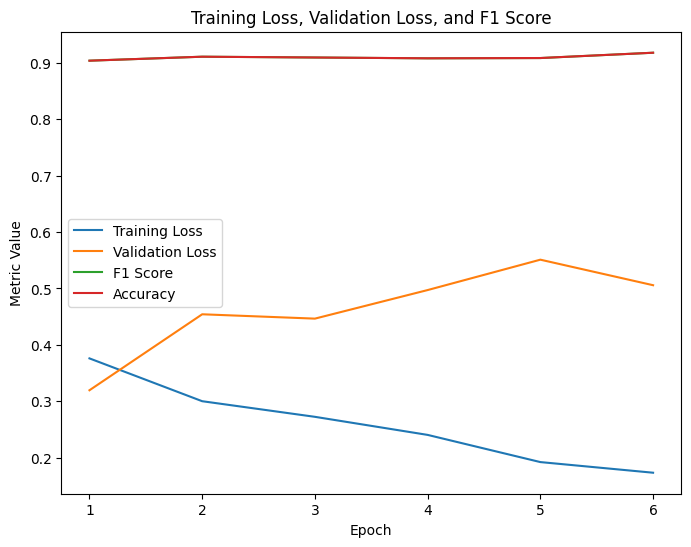

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.37593885328897614  0.31941045457199635  0.9039939195509822  0.904                  0.904182
2                     0.2999867904304777   0.45416806885623373  0.9110538598995194  0.9110538598995194     0.911054
3                     0.2722863798784984   0.4464652782650288   0.9096466186147053  0.9096466186147053     0.909647
4                     0.2402213712370207   0.49713921206749456  0.9081636971569036  0.9081636971569036     0.908164
5                     0.19200368484237068  0.5510301477067029   0.9086606577677915  0.9086606577677915     0.908661
6                     0.1731332144919578   0.5057340500744684   0.9181071278923016  0.9181071278923016     0.918107
Total Training Time                                                     

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.16105205068361186
Validation loss: 0.08300747232729043
F1 Score (weighted): 0.98541166778673


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.13906255574625953
Validation loss: 0.11624134902688509
F1 Score (weighted): 0.9811760954135837
13.65% Training loss decreased compared to the previous epoch
40.04% Validation loss increased compared to the previous epoch
0.43% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.10615686829634077
Validation loss: 0.10970066412624546
F1 Score (weighted): 0.9807056430757862
23.66% Training loss decreased compared to the previous epoch
5.63% Validation loss decreased compared to the previous epoch
0.05% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.09263688500875737
Validation loss: 0.09932924351013432
F1 Score (weighted): 0.9854117647058823
12.74% Training loss decreased compared to the previous epoch
9.45% Validation loss decreased compared to the previous epoch
0.48% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.07202251944024604
Validation loss: 0.13404180941670074
F1 Score (weighted): 0.9802344974812784
22.25% Training loss decreased compared to the previous epoch
34.95% Validation loss increased compared to the previous epoch
0.53% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.05240290976179704
Validation loss: 0.13868172274569024
F1 Score (weighted): 0.980235285363727
27.24% Training loss decreased compared to the previous epoch
3.46% Validation loss increased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 120.31693768898646 minutes
Final Accuracy: 0.9802352941176471
Final Precision: 0.9802370132238618


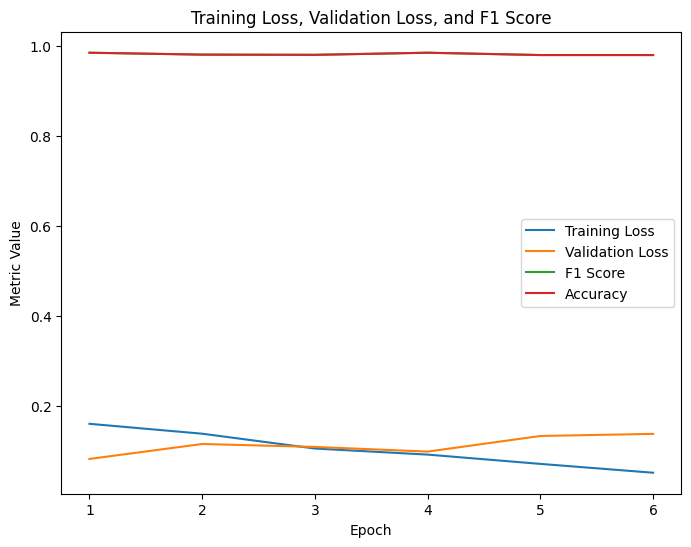

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.16105205068361186  0.08300747232729043  0.98541166778673    0.9854117647058823     0.985422
2                     0.13906255574625953  0.11624134902688509  0.9811760954135837  0.9811760954135837     0.981176
3                     0.10615686829634077  0.10970066412624546  0.9807056430757862  0.9807056430757862     0.980706
4                     0.09263688500875737  0.09932924351013432  0.9854117647058823  0.9854117647058823     0.985412
5                     0.07202251944024604  0.13404180941670074  0.9802344974812784  0.9802344974812784     0.980234
6                     0.05240290976179704  0.13868172274569024  0.980235285363727   0.980235285363727      0.980235
Total Training Time                                                     

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.061925250667562125
Validation loss: 0.02145618532564045
F1 Score (weighted): 0.9957650439215562


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.04614563045745522
Validation loss: 0.0167631580441891
F1 Score (weighted): 0.9962357548093564
25.48% Training loss decreased compared to the previous epoch
21.87% Validation loss decreased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.03499792918094681
Validation loss: 0.022208828347033818
F1 Score (weighted): 0.9952946935116954
24.16% Training loss decreased compared to the previous epoch
32.49% Validation loss increased compared to the previous epoch
0.09% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.025383766487549832
Validation loss: 0.016256202097090573
F1 Score (weighted): 0.9976472466230869
27.47% Training loss decreased compared to the previous epoch
26.8% Validation loss decreased compared to the previous epoch
0.24% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.022830821734504635
Validation loss: 0.02781409483178319
F1 Score (weighted): 0.9962356496735365
10.06% Training loss decreased compared to the previous epoch
71.1% Validation loss increased compared to the previous epoch
0.14% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.022854380492357385
Validation loss: 0.027083162621554822
F1 Score (weighted): 0.9957649143533578
0.1% Training loss increased compared to the previous epoch
2.63% Validation loss decreased compared to the previous epoch
0.05% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.015545549547911718
Validation loss: 0.028956512177347314
F1 Score (weighted): 0.9962356496735365
31.98% Training loss decreased compared to the previous epoch
6.92% Validation loss increased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.016915718319942607
Validation loss: 0.02804702626204018
F1 Score (weighted): 0.9967061452723216
8.81% Training loss increased compared to the previous epoch
3.14% Validation loss decreased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.011746317477138113
Validation loss: 0.027832677578820453
F1 Score (weighted): 0.9967061452723216
30.56% Training loss decreased compared to the previous epoch
0.76% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 180.53144923448562 minutes
Final Accuracy: 0.9967058823529412
Final Precision: 0.9967174552824258


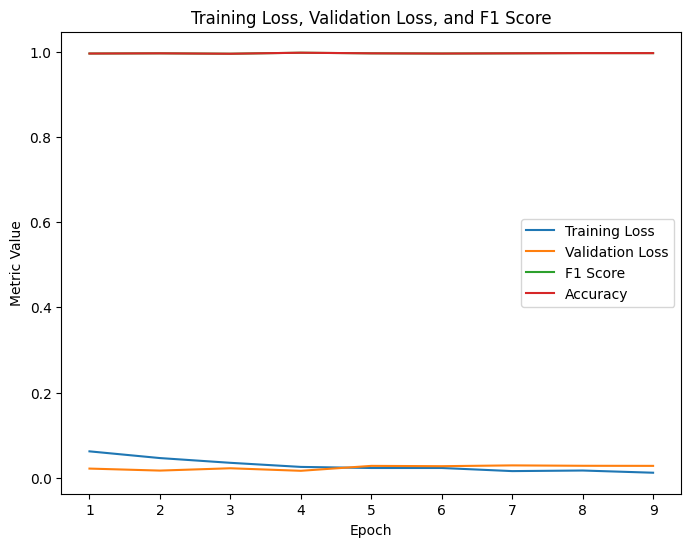

Epoch                 Training Loss         Validation Loss       F1 Score            Accuracy               Precision
--------------------  --------------------  --------------------  ------------------  ------------------  ------------
1                     0.061925250667562125  0.02145618532564045   0.9957650439215562  0.995764705882353       0.995776
2                     0.04614563045745522   0.0167631580441891    0.9962357548093564  0.9962357548093564      0.996236
3                     0.03499792918094681   0.022208828347033818  0.9952946935116954  0.9952946935116954      0.995295
4                     0.025383766487549832  0.016256202097090573  0.9976472466230869  0.9976472466230869      0.997647
5                     0.022830821734504635  0.02781409483178319   0.9962356496735365  0.9962356496735365      0.996236
6                     0.022854380492357385  0.027083162621554822  0.9957649143533578  0.9957649143533578      0.995765
7                     0.015545549547911718  0.02

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.017392784303124593
Validation loss: 0.0034020698677508783
F1 Score (weighted): 0.999058841461444


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.009491403703227437
Validation loss: 0.0029938778253616703
F1 Score (weighted): 0.9995294163520585
45.43% Training loss decreased compared to the previous epoch
12.0% Validation loss decreased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.00976621004989067
Validation loss: 4.5177459611789984e-05
F1 Score (weighted): 1.0
2.9% Training loss increased compared to the previous epoch
98.49% Validation loss decreased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.009001646349860956
Validation loss: 0.0008935692916319434
F1 Score (weighted): 0.9995294163520585
7.83% Training loss decreased compared to the previous epoch
1877.91% Validation loss increased compared to the previous epoch
0.05% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.006825414011062634
Validation loss: 0.0006815727326463717
F1 Score (weighted): 0.9995294163520585
24.18% Training loss decreased compared to the previous epoch
23.72% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.008243146164503593
Validation loss: 0.00019756375100790375
F1 Score (weighted): 1.0
20.77% Training loss increased compared to the previous epoch
71.01% Validation loss decreased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.004487808630059949
Validation loss: 0.00030201376708999874
F1 Score (weighted): 1.0
45.56% Training loss decreased compared to the previous epoch
52.87% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.005702544359113149
Validation loss: 0.0003020159519005668
F1 Score (weighted): 1.0
27.07% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 160.50281142791113 minutes
Final Accuracy: 1.0
Final Precision: 1.0


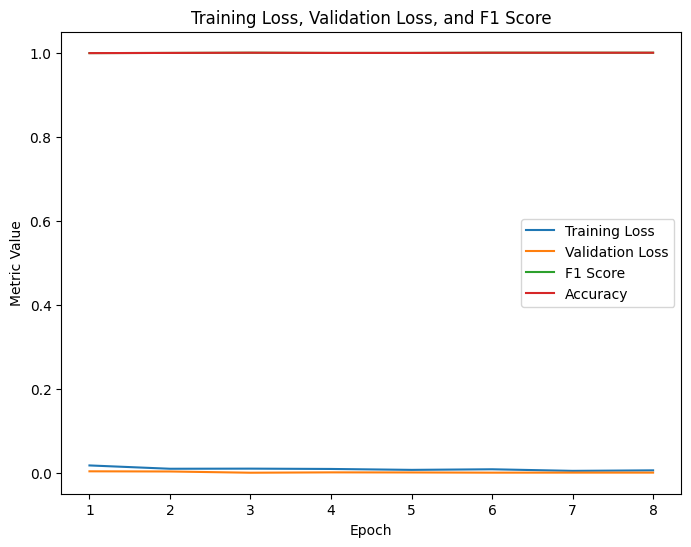

Epoch                 Training Loss         Validation Loss         F1 Score            Accuracy              Precision
--------------------  --------------------  ----------------------  ------------------  ------------------  -----------
1                     0.017392784303124593  0.0034020698677508783   0.999058841461444   0.9990588235294118     0.999061
2                     0.009491403703227437  0.0029938778253616703   0.9995294163520585  0.9995294163520585     0.999529
3                     0.00976621004989067   4.5177459611789984e-05  1.0                 1.0                    1
4                     0.009001646349860956  0.0008935692916319434   0.9995294163520585  0.9995294163520585     0.999529
5                     0.006825414011062634  0.0006815727326463717   0.9995294163520585  0.9995294163520585     0.999529
6                     0.008243146164503593  0.00019756375100790375  1.0                 1.0                    1
7                     0.004487808630059949  0.00030201

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.005707675847336876
Validation loss: 1.6212739463331412e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0043809888660534604
Validation loss: 1.6203664345798438e-06
F1 Score (weighted): 1.0
23.24% Training loss decreased compared to the previous epoch
0.06% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.004540275042655868
Validation loss: 1.6849607305002928e-06
F1 Score (weighted): 1.0
3.64% Training loss increased compared to the previous epoch
3.99% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.004965296757361917
Validation loss: 1.6205344965284956e-06
F1 Score (weighted): 1.0
9.36% Training loss increased compared to the previous epoch
3.82% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0068925535695796665
Validation loss: 1.6211731093669624e-06
F1 Score (weighted): 1.0
38.81% Training loss increased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.003924320039660925
Validation loss: 1.6204000452813672e-06
F1 Score (weighted): 1.0
43.06% Training loss decreased compared to the previous epoch
0.05% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0052979006029039745
Validation loss: 1.619996701476896e-06
F1 Score (weighted): 1.0
35.0% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.004899781177503069
Validation loss: 1.6223159037774434e-06
F1 Score (weighted): 1.0
7.51% Training loss decreased compared to the previous epoch
0.14% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.004960881357726012
Validation loss: 1.6203328128729214e-06
F1 Score (weighted): 1.0
1.25% Training loss increased compared to the previous epoch
0.12% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.004838821099133559
Validation loss: 1.6217108980877863e-06
F1 Score (weighted): 1.0
2.46% Training loss decreased compared to the previous epoch
0.09% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.006674116041577351
Validation loss: 1.6204000501963998e-06
F1 Score (weighted): 1.0
37.93% Training loss increased compared to the previous epoch
0.08% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.006086658508822165
Validation loss: 1.6210386717964462e-06
F1 Score (weighted): 1.0
8.8% Training loss decreased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 240.81393340826034 minutes
Final Accuracy: 1.0
Final Precision: 1.0


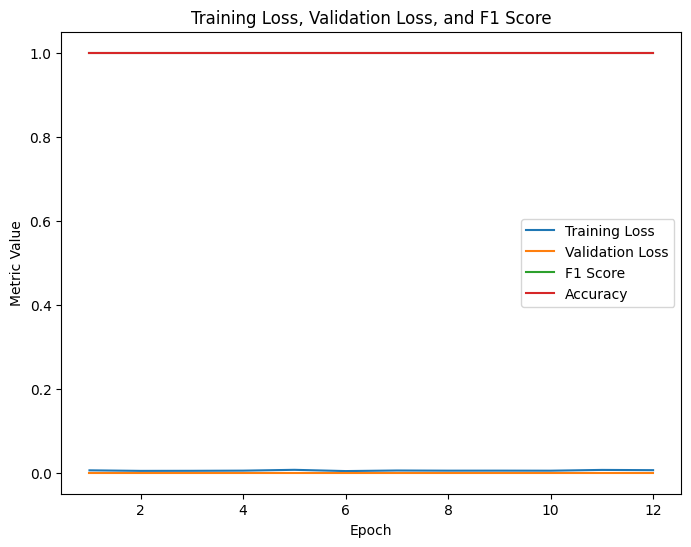

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.005707675847336876   1.6212739463331412e-06  1.0         1.0               1
2                     0.0043809888660534604  1.6203664345798438e-06  1.0         1.0               1
3                     0.004540275042655868   1.6849607305002928e-06  1.0         1.0               1
4                     0.004965296757361917   1.6205344965284956e-06  1.0         1.0               1
5                     0.0068925535695796665  1.6211731093669624e-06  1.0         1.0               1
6                     0.003924320039660925   1.6204000452813672e-06  1.0         1.0               1
7                     0.0052979006029039745  1.619996701476896e-06   1.0         1.0               1
8                     0.004899781177503069   1.6223159037774434e-06  1.0         1.

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.006349369388002399
Validation loss: 0.0009140749587400801
F1 Score (weighted): 0.9995294073860364


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.005538658871898718
Validation loss: 0.0009140744881691028
F1 Score (weighted): 0.9995294073860364
12.77% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.005956708632634494
Validation loss: 0.0009140757317961521
F1 Score (weighted): 0.9995294073860364
7.55% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.00440786219607982
Validation loss: 0.0009140766729018851
F1 Score (weighted): 0.9995294073860364
26.0% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0045597646877701715
Validation loss: 0.0009140738159514395
F1 Score (weighted): 0.9995294073860364
3.45% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0048944190466547076
Validation loss: 0.0009140746226186938
F1 Score (weighted): 0.9995294073860364
7.34% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.004830933187662165
Validation loss: 0.0009140732445428014
F1 Score (weighted): 0.9995294073860364
1.3% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.005587133560522527
Validation loss: 0.0009140750595663615
F1 Score (weighted): 0.9995294073860364
15.65% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.005210668873982271
Validation loss: 0.0009140733453774169
F1 Score (weighted): 0.9995294073860364
6.74% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.007987073589298234
Validation loss: 0.0009140755973462939
F1 Score (weighted): 0.9995294073860364
53.28% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.004230588262442745
Validation loss: 0.0009140747907224736
F1 Score (weighted): 0.9995294073860364
47.03% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0071195023794521925
Validation loss: 0.0009140747906758342
F1 Score (weighted): 0.9995294073860364
68.29% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 240.90388668775557 minutes
Final Accuracy: 0.9995294117647059
Final Precision: 0.9995298458866942


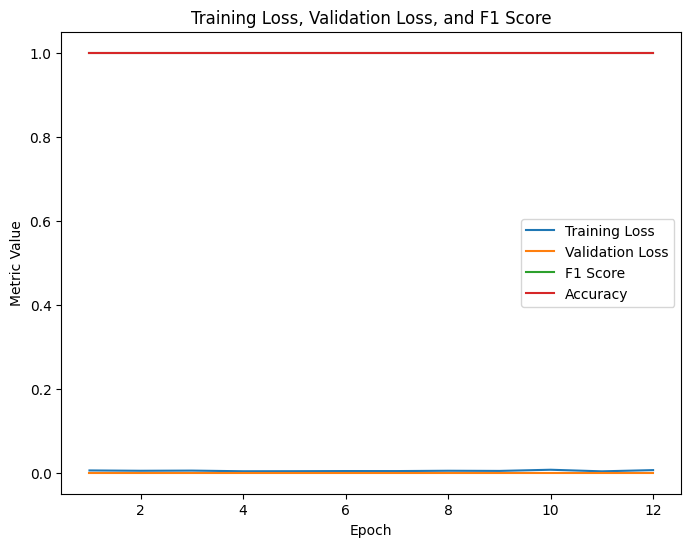

Epoch                 Training Loss          Validation Loss        F1 Score            Accuracy               Precision
--------------------  ---------------------  ---------------------  ------------------  ------------------  ------------
1                     0.006349369388002399   0.0009140749587400801  0.9995294073860364  0.9995294117647059      0.99953
2                     0.005538658871898718   0.0009140744881691028  0.9995294073860364  0.9995294073860364      0.999529
3                     0.005956708632634494   0.0009140757317961521  0.9995294073860364  0.9995294073860364      0.999529
4                     0.00440786219607982    0.0009140766729018851  0.9995294073860364  0.9995294073860364      0.999529
5                     0.0045597646877701715  0.0009140738159514395  0.9995294073860364  0.9995294073860364      0.999529
6                     0.0048944190466547076  0.0009140746226186938  0.9995294073860364  0.9995294073860364      0.999529
7                     0.004830933

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.006243017794611291
Validation loss: 7.210928964396819e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.005164845296660643
Validation loss: 7.213584264951023e-06
F1 Score (weighted): 1.0
17.27% Training loss decreased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.004661376279956956
Validation loss: 7.212138979462407e-06
F1 Score (weighted): 1.0
9.75% Training loss decreased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0066143636436909285
Validation loss: 7.211265064600461e-06
F1 Score (weighted): 1.0
41.9% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.005574587022321233
Validation loss: 7.212475090591311e-06
F1 Score (weighted): 1.0
15.72% Training loss decreased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.004971999385396243
Validation loss: 7.211063389920164e-06
F1 Score (weighted): 1.0
10.81% Training loss decreased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 120.53702173233032 minutes
Final Accuracy: 1.0
Final Precision: 1.0


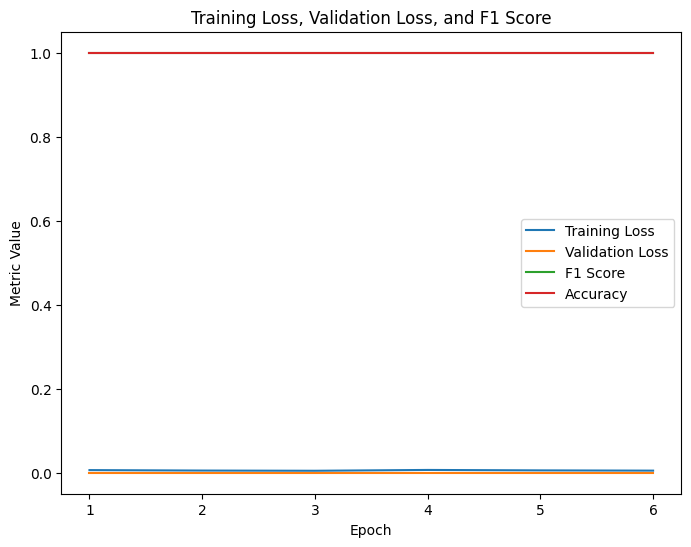

Epoch                 Training Loss          Validation Loss        F1 Score    Accuracy      Precision
--------------------  ---------------------  ---------------------  ----------  ----------  -----------
1                     0.006243017794611291   7.210928964396819e-06  1.0         1.0               1
2                     0.005164845296660643   7.213584264951023e-06  1.0         1.0               1
3                     0.004661376279956956   7.212138979462407e-06  1.0         1.0               1
4                     0.0066143636436909285  7.211265064600461e-06  1.0         1.0               1
5                     0.005574587022321233   7.212475090591311e-06  1.0         1.0               1
6                     0.004971999385396243   7.211063389920164e-06  1.0         1.0               1
Total Training Time                                                                            7232.22
Final Precision                                                                          

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.005715065097097536
Validation loss: 4.3755580335121184e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.004960226223366621
Validation loss: 4.376734416559902e-06
F1 Score (weighted): 1.0
13.21% Training loss decreased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.004891016734488271
Validation loss: 4.375356365242733e-06
F1 Score (weighted): 1.0
1.4% Training loss decreased compared to the previous epoch
0.03% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.005301027829753238
Validation loss: 4.375457154554467e-06
F1 Score (weighted): 1.0
8.38% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0053012018662780755
Validation loss: 4.378213319000679e-06
F1 Score (weighted): 1.0
0.0% Training loss increased compared to the previous epoch
0.06% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.004875270482331573
Validation loss: 4.377641920192711e-06
F1 Score (weighted): 1.0
8.03% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0056310926786739
Validation loss: 4.3768352559301725e-06
F1 Score (weighted): 1.0
15.5% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0037582090063735837
Validation loss: 4.375356362357823e-06
F1 Score (weighted): 1.0
33.26% Training loss decreased compared to the previous epoch
0.03% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0035718388542094063
Validation loss: 4.375860564765301e-06
F1 Score (weighted): 1.0
4.96% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.005677873691839996
Validation loss: 4.378986381376697e-06
F1 Score (weighted): 1.0
58.96% Training loss increased compared to the previous epoch
0.07% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.004280464898487491
Validation loss: 4.376230262982203e-06
F1 Score (weighted): 1.0
24.61% Training loss decreased compared to the previous epoch
0.06% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.004978691562727025
Validation loss: 4.378112522797215e-06
F1 Score (weighted): 1.0
16.31% Training loss increased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.005307474286239357
Validation loss: 4.378583005731364e-06
F1 Score (weighted): 1.0
6.6% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 261.16732643445334 minutes
Final Accuracy: 1.0
Final Precision: 1.0


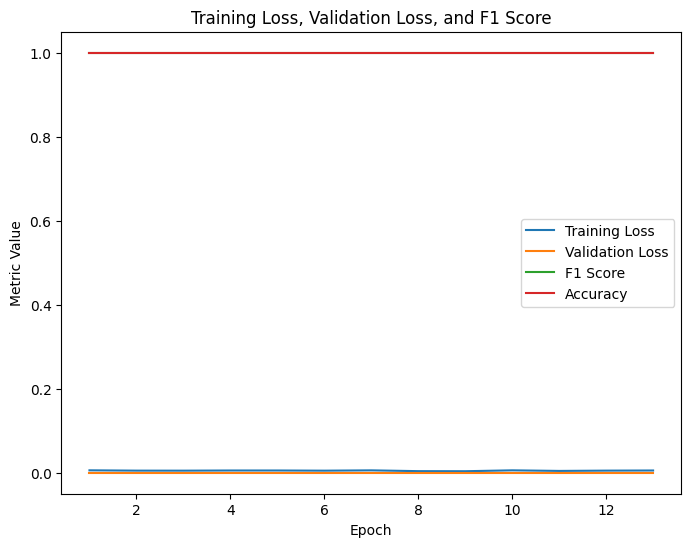

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.005715065097097536   4.3755580335121184e-06  1.0         1.0               1
2                     0.004960226223366621   4.376734416559902e-06   1.0         1.0               1
3                     0.004891016734488271   4.375356365242733e-06   1.0         1.0               1
4                     0.005301027829753238   4.375457154554467e-06   1.0         1.0               1
5                     0.0053012018662780755  4.378213319000679e-06   1.0         1.0               1
6                     0.004875270482331573   4.377641920192711e-06   1.0         1.0               1
7                     0.0056310926786739     4.3768352559301725e-06  1.0         1.0               1
8                     0.0037582090063735837  4.375356362357823e-06   1.0         1.

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0052173738399149145
Validation loss: 1.3448053477555164e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.00458803080752882
Validation loss: 1.346317871262125e-06
F1 Score (weighted): 1.0
12.06% Training loss decreased compared to the previous epoch
0.11% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.007777922492778778
Validation loss: 1.3473934413579365e-06
F1 Score (weighted): 1.0
69.53% Training loss increased compared to the previous epoch
0.08% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.005669833834030192
Validation loss: 1.3451414655624536e-06
F1 Score (weighted): 1.0
27.1% Training loss decreased compared to the previous epoch
0.17% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.00835377114546238
Validation loss: 1.3452759060178801e-06
F1 Score (weighted): 1.0
47.34% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.005018473692372824
Validation loss: 1.3451414613686488e-06
F1 Score (weighted): 1.0
39.93% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 120.54678706328075 minutes
Final Accuracy: 1.0
Final Precision: 1.0


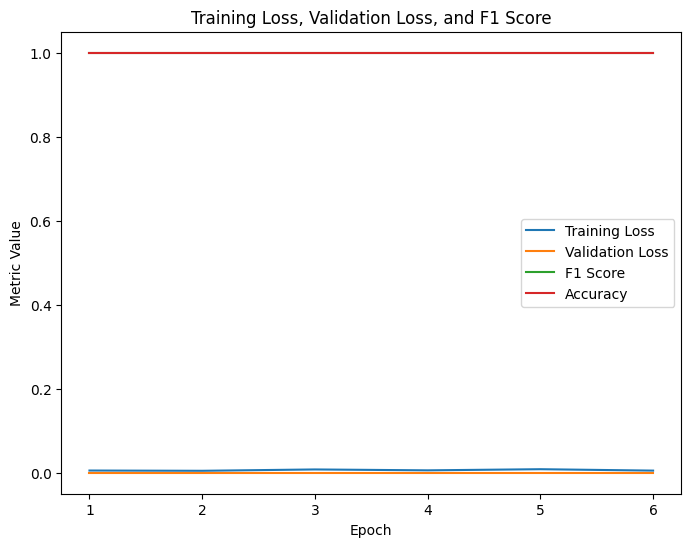

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.0052173738399149145  1.3448053477555164e-06  1.0         1.0               1
2                     0.00458803080752882    1.346317871262125e-06   1.0         1.0               1
3                     0.007777922492778778   1.3473934413579365e-06  1.0         1.0               1
4                     0.005669833834030192   1.3451414655624536e-06  1.0         1.0               1
5                     0.00835377114546238    1.3452759060178801e-06  1.0         1.0               1
6                     0.005018473692372824   1.3451414613686488e-06  1.0         1.0               1
Total Training Time                                                                             7232.81
Final Precision                                                                 

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.004525863596328162
Validation loss: 1.3471234070973201e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.004034782650213963
Validation loss: 1.3471570125098413e-06
F1 Score (weighted): 1.0
10.85% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.007548997817812825
Validation loss: 1.3465856272182122e-06
F1 Score (weighted): 1.0
87.1% Training loss increased compared to the previous epoch
0.04% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.006493741224705326
Validation loss: 1.3471234047466525e-06
F1 Score (weighted): 1.0
13.98% Training loss decreased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.00537856968983892
Validation loss: 1.348367038901374e-06
F1 Score (weighted): 1.0
17.17% Training loss decreased compared to the previous epoch
0.09% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0027524101159111984
Validation loss: 1.3466864616200263e-06
F1 Score (weighted): 1.0
48.83% Training loss decreased compared to the previous epoch
0.12% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.005446143098830572
Validation loss: 1.3462495112276999e-06
F1 Score (weighted): 1.0
97.87% Training loss increased compared to the previous epoch
0.03% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.004787865274522978
Validation loss: 1.3470561809929376e-06
F1 Score (weighted): 1.0
12.09% Training loss decreased compared to the previous epoch
0.06% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.004047038904830152
Validation loss: 1.3479636970201763e-06
F1 Score (weighted): 1.0
15.47% Training loss decreased compared to the previous epoch
0.07% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.004439420331111456
Validation loss: 1.3466192300396564e-06
F1 Score (weighted): 1.0
9.7% Training loss increased compared to the previous epoch
0.1% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.005250995292547854
Validation loss: 1.3471906402537058e-06
F1 Score (weighted): 1.0
18.28% Training loss increased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/2391 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.005482041116393875
Validation loss: 1.3476275857309996e-06
F1 Score (weighted): 1.0
4.4% Training loss increased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 241.06335548559824 minutes
Final Accuracy: 1.0
Final Precision: 1.0


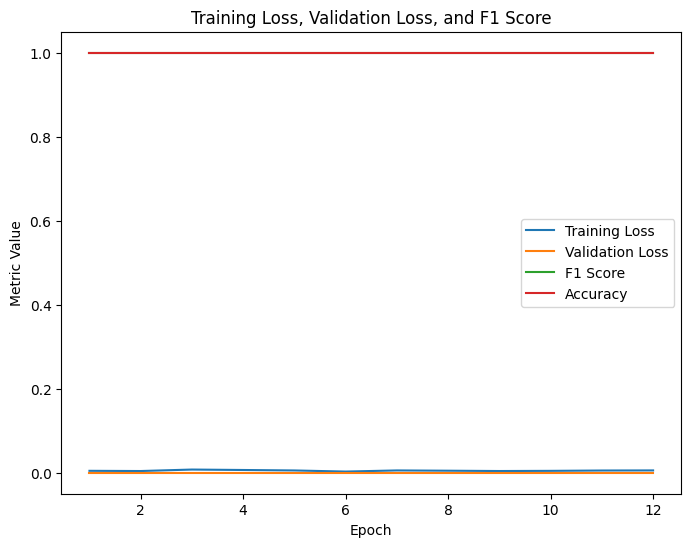

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.004525863596328162   1.3471234070973201e-06  1.0         1.0               1
2                     0.004034782650213963   1.3471570125098413e-06  1.0         1.0               1
3                     0.007548997817812825   1.3465856272182122e-06  1.0         1.0               1
4                     0.006493741224705326   1.3471234047466525e-06  1.0         1.0               1
5                     0.00537856968983892    1.348367038901374e-06   1.0         1.0               1
6                     0.0027524101159111984  1.3466864616200263e-06  1.0         1.0               1
7                     0.005446143098830572   1.3462495112276999e-06  1.0         1.0               1
8                     0.004787865274522978   1.3470561809929376e-06  1.0         1.

In [19]:
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_val = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # train_model(trainer, dataloader_train, dataloader_val, epochs, patience)

    try:
        train_model(trainer, dataloader_train, dataloader_val, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

In [20]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_bert_gpt_ft_epoch10.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 1063/1063

Class: 1
Accuracy: 1062/1062



In [21]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_bert_gpt_ft_epoch10.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_train)
accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 9559/9562

Class: 1
Accuracy: 9562/9563

